# VSB Powerline 

with ts shift augmentation

phase 1 as a second model - predict separately, phase 0,2 as model 1

using spectrograms created in vsb_powerline_spectrograms

In [121]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [122]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [123]:
from fastai.vision import *

In [124]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [125]:
import fastai
print(fastai.__version__)

1.0.41.dev0


In [126]:
torch.cuda.set_device(1)

In [127]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [128]:
DATE

'20190120'

In [129]:
UID

'c4e31352'

In [130]:
MODEL_0_2_NAME='300_ts_shift_aug_phase_0-2_model'
MODEL_1_NAME='300_ts_shift_aug_phase_1_model'

In [131]:
image_size=300
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [132]:
path = Path('../input/')
train_path = path/'train_300_ts_aug_viridis-60_10/'

In [133]:
test_path = path/'test_300_ts_aug_viridis-60-10/'

In [134]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [135]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [136]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [137]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [138]:
train_files = [f for f in listdir(str(train_path)) if isfile(join(str(train_path), f))]

In [139]:
train_files[:10]

['6430.jpg',
 '6278_neg_aug_875.jpg',
 '5197.jpg',
 '8171.jpg',
 '5284_neg_aug_75.jpg',
 '4413.jpg',
 '709_neg_aug_50.jpg',
 '4913.jpg',
 '3447.jpg',
 '5030.jpg']

In [140]:
aug_sig_names=[]
sigs=[]
for f in train_files:
    f_name=f.split('.jpg')[0]
    if '_' in f_name:
        sigs.append(f_name.split('_')[0])
        aug_sig_names.append(f_name)

In [141]:
len(aug_sig_names)

6300

In [142]:
idms=[]
phases=[]
targets=[]
for f, s in zip(aug_sig_names, sigs):
    row = train_df.loc[train_df['signal_id'] == int(s)]
    assert row is not None
    idms.append(row['id_measurement'].values[0])
    phases.append(row['phase'].values[0])
    targets.append(row['target'].values[0])
    

In [143]:
aug_df = pd.DataFrame([aug_sig_names, idms, phases, targets])

In [144]:
aug_df=aug_df.T


In [145]:
aug_df.columns=['signal_id','id_measurement','phase','target']
aug_df.head()

,signal_id,id_measurement,phase,target
0,6278_neg_aug_875,2092,2,1
1,5284_neg_aug_75,1761,1,1
2,709_neg_aug_50,236,1,1
3,2418_pos_aug_625,806,0,1
4,5983_neg_aug_125,1994,1,1


#### combine into one dataframe

In [146]:
train_df = pd.concat([train_df, aug_df], ignore_index=True)

In [147]:
len(train_df)

15012

In [148]:
train_df['target'].value_counts()

0    8187
1    6825
Name: target, dtype: int64

Much better than raw dataset - we could still do with bumping up the number of bad signals a bit though

In [149]:
#phase1
train_df_phase_1=train_df.loc[train_df['phase'] == 1]
train_df_phase_0_2=train_df.loc[train_df['phase'] != 1]

In [150]:
train_df_phase_1['phase'].value_counts()

1    4896
Name: phase, dtype: int64

In [151]:
train_df_phase_0_2['phase'].value_counts()

2    5076
0    5040
Name: phase, dtype: int64

In [152]:
train_df_phase_0_2.reset_index(drop=True, inplace=True)

In [153]:
df_val_0_2 = train_df_phase_0_2.sample(frac=0.2)
val_idxs_0_2=df_val_0_2.index.values

In [154]:
val_idxs_0_2[:10]

array([8522, 7975, 8851,  589, 3100, 5543, 2360, 4346,  521, 1594])

In [155]:
df_val_0_2.head()

,signal_id,id_measurement,phase,target
8522,4143_neg_aug_125,1381,0,1
7975,7467_pos_aug_375,2489,0,1
8851,1449_neg_aug_75,483,0,1
589,884,294,2,0
3100,4650,1550,0,0


In [156]:
train_df_phase_1.reset_index(drop=True, inplace=True)

In [157]:
df_val_1 = train_df_phase_1.sample(frac=0.2)
val_idxs_1=df_val_1.index.values

## Phase 0, 2

In [158]:
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)

In [159]:
data_0_2 = (ImageItemList.from_df(train_df_phase_0_2, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs_0_2)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

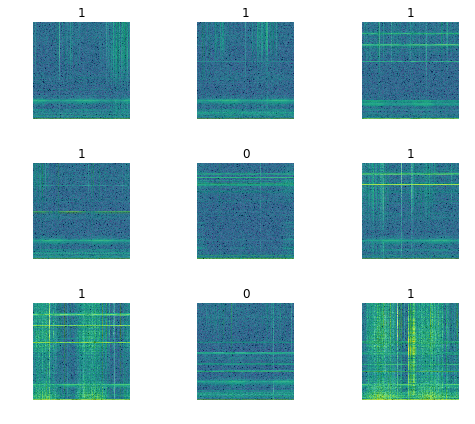

In [160]:
data_0_2.show_batch(rows=3, figsize=(7,6))

### Training: resnet34

In [161]:
learn_0_2 = create_cnn(data_0_2, models.resnet34, metrics=error_rate)

In [162]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


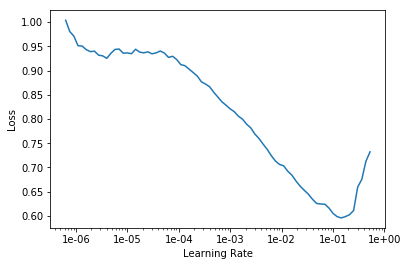

In [163]:
learn_0_2.lr_find()
learn_0_2.recorder.plot()

#### Fit

In [164]:
learn_0_2.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,error_rate
1,0.397786,0.256391,0.103312
2,0.245017,0.180139,0.070687
3,0.164013,0.161340,0.059812
4,0.127700,0.145752,0.055858
5,0.092389,0.138829,0.053386


## Phase 1

In [165]:
data_1 = (ImageItemList.from_df(train_df_phase_1, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs_1)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

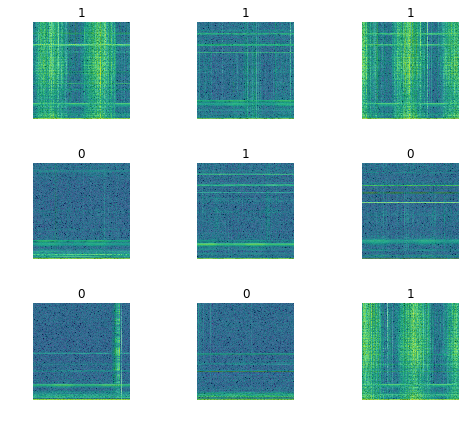

In [166]:
data_1.show_batch(rows=3, figsize=(7,6))

### Training: resnet34

In [167]:
learn_1 = create_cnn(data_1, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


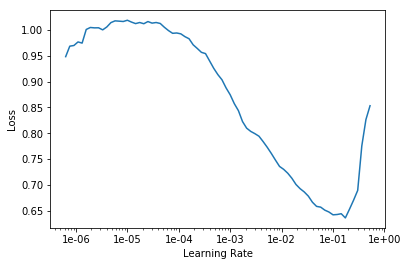

In [168]:
learn_1.lr_find()
learn_1.recorder.plot()

#### Fit

In [169]:
learn_1.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,error_rate
1,0.371019,0.323869,0.110317
2,0.254489,0.270621,0.118488
3,0.186269,0.171228,0.071502
4,0.119736,0.102777,0.040858
5,0.064423,0.080016,0.026558


### cf combined model

In [170]:
val_idxs = np.append(val_idxs_1, val_idxs_0_2)

In [171]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [172]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


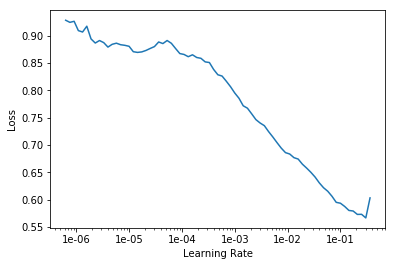

In [173]:
learn.lr_find()
learn.recorder.plot()

In [174]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,error_rate
1,0.237055,0.447052,0.165223
2,0.158270,0.145256,0.064957
3,0.130505,0.206725,0.066622
4,0.077683,0.128054,0.040973
5,0.043294,0.106533,0.036309


In [85]:
learn.save(f'aug_stage-1_{MODEL_NAME}_{UID}_{DATE}')

## Results

In [86]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

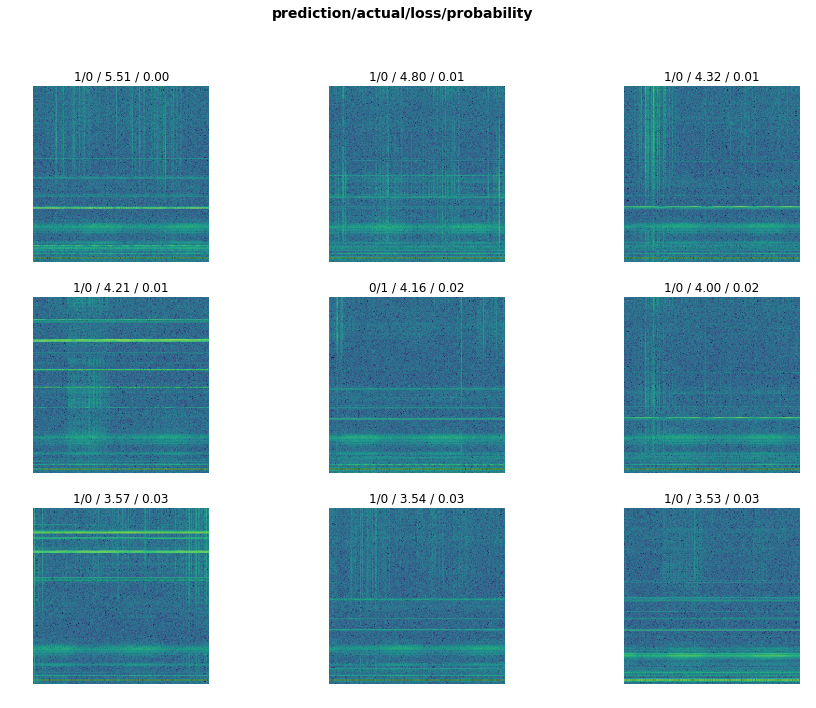

In [87]:
interp.plot_top_losses(9, figsize=(15,11))

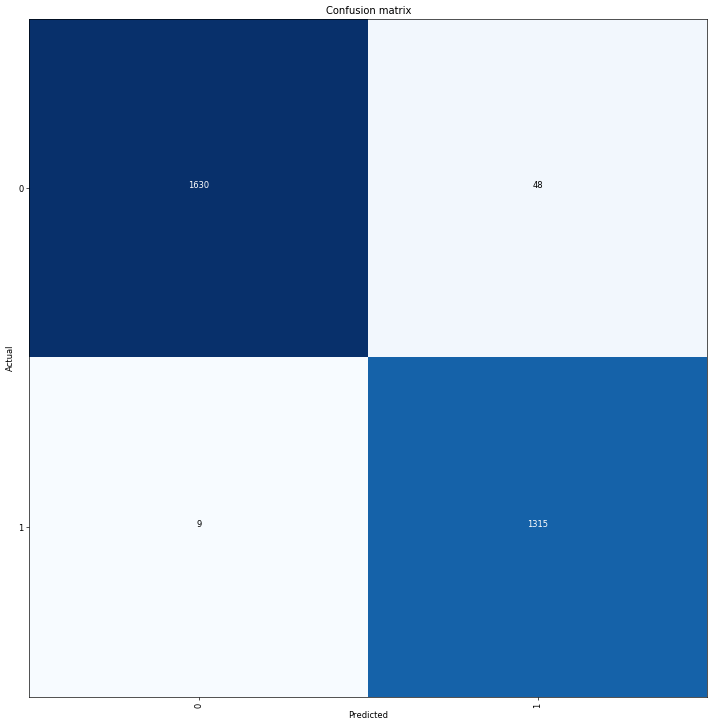

In [88]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [89]:
'''train_300_ts_aug_viridis-60_10
[(0, 1, 48), (1, 0, 9)]
'''
interp.most_confused(min_val=2)

[(0, 1, 48), (1, 0, 9)]

## Unfreezing, fine-tuning, and learning rates

In [90]:
learn.unfreeze()

In [91]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.116106,0.076931,0.023651


In [96]:
learn.load(f'aug_stage-1_{MODEL_NAME}_{UID}_{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12010 items)
[Category 0, Category 0, Category 1, Category 1, Category 1]...
Path: ../input/train_300_ts_aug_viridis-60_10
x: ImageItemList (12010 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_ts_aug_viridis-60_10;

Valid: LabelList
y: CategoryList (3002 items)
[Category 1, Category 0, Category 0, Category 0, Category 0]...
Path: ../input/train_300_ts_aug_viridis-60_10
x: ImageItemList (3002 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_ts_aug_viridis-60_10;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
 

In [93]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


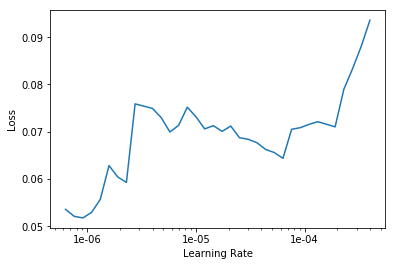

In [94]:
learn.recorder.plot()

In [97]:
'''
train_300_ts_aug_viridis-60_10
best after 2 epochs:
epoch 	train_loss 	valid_loss 	error_rate
1 	0.053172 	0.057430 	0.019654
2 	0.045575 	0.058810 	0.018321
'''

learn.unfreeze()
#tried 5 but was increasing after 2
learn.fit_one_cycle(2, max_lr=5e-7)

epoch,train_loss,valid_loss,error_rate
1,0.053172,0.057430,0.019654
2,0.045575,0.058810,0.018321


In [98]:
learn.save(f'aug_stage-2_unfeeze_{MODEL_NAME}_{UID}_{DATE}')

### 1x1 prediction

In [99]:
#test_images = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [100]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [101]:
len(test_images)

20337

In [102]:
assert 20337 == len(test_images)

In [103]:
img = open_image(test_images[0])
type(img)

fastai.vision.image.Image

In [104]:
cat, val, probs=learn.predict(img)

In [105]:
cat.__str__()

'0'

In [106]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [107]:
df_sub=pd.DataFrame.from_dict(d, orient='index')

In [108]:
df_sub=df_sub.reset_index()
df_sub.head()

,index,0
0,8847,0
1,25536,0
2,24202,0
3,11043,0
4,25522,0


In [109]:
df_sub.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)

In [110]:
df_sub.head()

,signal_id,target
0,8847,0
1,25536,0
2,24202,0
3,11043,0
4,25522,0


In [111]:
len(df_sub)

20337

In [112]:
df_sub.to_csv(path/f'submissions/submission_aug_stage-2_unfeeze_{MODEL_NAME}_{DATE}_{UID}.csv', index=False)
#submission 6. 0.383 - worse than initial submission


## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [113]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg', bs=8)
#data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
#                                   size=image_size, bs=bs//2).normalize(imagenet_stats)

In [114]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


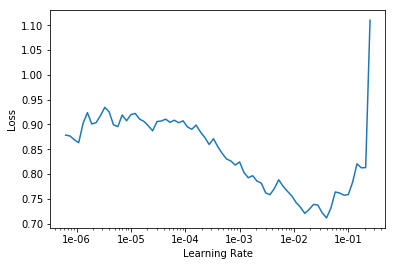

In [115]:
learn.lr_find()
learn.recorder.plot()

In [116]:
max_lr = 5e-4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(8, lrs)

epoch,train_loss,valid_loss,error_rate
1,0.424089,0.286836,0.121919
2,0.357203,0.246099,0.101932
3,0.311069,0.214128,0.082278
4,0.269745,0.201571,0.078947
5,0.256514,0.187087,0.064290
6,0.223774,0.174839,0.062625
7,0.234134,0.170159,0.060293
8,0.237448,0.171822,0.061626


In [57]:
#learn.fit_one_cycle(8)

In [118]:
learn.save(f'aug_stage-1-50_{MODEL_NAME}_{UID}_{DATE}')

In [119]:
learn.unfreeze()


In [121]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


TypeError: slice indices must be integers or None or have an __index__ method

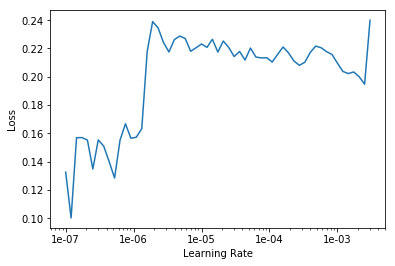

In [122]:
learn.recorder.plot(skip_start=0, skip_end=5)

In [123]:
learn.fit_one_cycle(3, max_lr=1e-7)

epoch,train_loss,valid_loss,error_rate
1,0.237639,0.172403,0.060293
2,0.203806,0.170353,0.058628
3,0.194712,0.173136,0.062958


In [126]:
learn.save(f'aug_stage-2-50_{MODEL_NAME}_{UID}_{DATE}')

In [127]:
learn.fit_one_cycle(3, max_lr=1e-7)

epoch,train_loss,valid_loss,error_rate
1,0.197531,0.173395,0.065956
2,0.222594,0.167821,0.058961
3,0.227089,0.174606,0.065956


In [128]:
learn.save(f'aug_stage-2-2-50_{MODEL_NAME}_{UID}_{DATE}')

In [129]:
#learn.load('baseline_stage-1-50');

In [130]:
interp = ClassificationInterpretation.from_learner(learn)

In [131]:
interp.most_confused(min_val=2)

[(0, 1, 143), (1, 0, 55)]

In [132]:
### Predict

In [133]:
learn.load(f'aug_stage-2-50_{MODEL_NAME}_{UID}_{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12010 items)
[Category 0, Category 1, Category 1, Category 1, Category 0]...
Path: ../input/train_300_ts_aug_viridis-60_10
x: ImageItemList (12010 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_ts_aug_viridis-60_10;

Valid: LabelList
y: CategoryList (3002 items)
[Category 1, Category 0, Category 1, Category 0, Category 0]...
Path: ../input/train_300_ts_aug_viridis-60_10
x: ImageItemList (3002 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: ../input/train_300_ts_aug_viridis-60_10;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, s

In [134]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [135]:
df_sub_50_u=pd.DataFrame.from_dict(d, orient='index')

In [136]:
df_sub_50_u=df_sub_50_u.reset_index()


In [137]:
df_sub_50_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_50_u.head()

,signal_id,target
0,8847,0
1,25536,1
2,24202,0
3,11043,1
4,25522,0


In [138]:
df_sub_50_u.to_csv(path/f'submissions/submission_aug_resnet-50_unfeeze-2-2_{MODEL_NAME}_{DATE}_{UID}.csv', index=False)

In [ ]:
#submission 3 0.478
#submission_aug_resnet-50_unfeeze-2-2_20181229_d1a603dc.csv
